In [1]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

Matplotlib created a temporary cache directory at /tmp/matplotlib-5swdc07q because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-11-28 15:57:43.656618: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 15:57:43.683307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 15:57:43.683344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 15:57:43.684560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable

You have TensorFlow version 2.15.0


In [2]:
sentences = pd.read_csv('grand_sentences.csv',encoding='latin-1')
sentences['Sentence'] = sentences['Sentence'].replace(np.nan, ' ')
sentences.drop("Unnamed: 0", axis = 1, inplace=True)
sentences

,Author,Sentence
0,Austen,The family of Dashwood had long been settled i...
1,Austen,"Their estatewas large, and their residence was..."
2,Austen,"The late owner of this estate was a singleman,..."
3,Austen,"But herdeath, which happened ten years before ..."
4,Austen,"Henry Dashwood, the legalinheritor of the Norl..."
...,...,...
16882,Fitzgerald,Nowâshe was thinkingâIâve earned a tim...
16883,Fitzgerald,He must know that because his laws are like th...
16884,Fitzgerald,Rosemary was rightâpresently he detached ...
16885,Fitzgerald,They looked out over the Mediterranean.


In [3]:
# Split the data into training and testing sets
train_sentences, test_sentences, train_authors, test_authors = train_test_split(sentences['Sentence'],
                                                                                sentences['Author'],
                                                                                test_size=0.2,
                                                                                random_state=42)
print ("Train size: %d" % int(len(train_sentences)))
print ("Test size: %d" % int(len(test_sentences)))

Train size: 13509
Test size: 3378


In [4]:
max_words = 50000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [5]:
tokenize.fit_on_texts(train_sentences) # only fit on train
X_train = tokenize.texts_to_matrix(train_sentences)
X_test = tokenize.texts_to_matrix(test_sentences)

In [6]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_authors)
y_train = encoder.transform(train_authors)
y_test = encoder.transform(test_authors)

In [7]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [8]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (13509, 50000)
X_test shape: (3378, 50000)
y_train shape: (13509, 8)
y_test shape: (3378, 8)


In [17]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 512
epochs = 2

In [18]:
# Build the model
model = Sequential()

model.add(Dense(2048, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Additional layers
model.add(Dense(1024))  # New hidden layer
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))  # New hidden layer
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/2


2023-11-28 16:01:16.224887: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2431600000 exceeds 10% of free system memory.


24/24 [==============================] - 18s 725ms/step - loss: 1.7725 - accuracy: 0.3350 - val_loss: 1.1607 - val_accuracy: 0.6055
Epoch 2/2
24/24 [==============================] - 17s 725ms/step - loss: 0.7417 - accuracy: 0.7528 - val_loss: 0.7799 - val_accuracy: 0.7439


In [20]:
# Evaluate the accuracy of our trained model
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 1s 134ms/step - loss: 0.7800 - accuracy: 0.7425
Test score: 0.779998779296875
Test accuracy: 0.7424511313438416


In [21]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

pred_correct = 0
pred_incorrect = 0

for i in range(20, 45):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_sentences.iloc[i][:80], "...")
    author_actual = test_authors.iloc[i]
    print('Actual author:' + author_actual)
    print("Predicted author: " + predicted_label + "\n")
    if author_actual == predicted_label:
        pred_correct += 1
    else:
        pred_incorrect += 1

print("Correctly predicted:", pred_correct, "  Incorrectly predicted:", pred_incorrect,
      "  Percentage:", 100 * pred_correct / (pred_correct + pred_incorrect))

1/1 [==============================] - 0s 129ms/step
They used to go on doing this even when they were pregnant. ...
Actual author:Orwell
Predicted author: Orwell

1/1 [==============================] - 0s 26ms/step
What I can't stand about him is hisway with other people--his way of treating an ...
Actual author:Lawrence
Predicted author: Fitzgerald

1/1 [==============================] - 0s 26ms/step
I crossed a railroad overpass and reached a bunch ofshacks where two highways fo ...
Actual author:Kerouac
Predicted author: Kerouac

1/1 [==============================] - 0s 26ms/step
The face shelifted to her dancers was the same which, when she saw him, alwayslo ...
Actual author:Wharton
Predicted author: Faulkner

1/1 [==============================] - 0s 26ms/step
The boards look like strips of sulphur. ...
Actual author:Faulkner
Predicted author: Hemingway

1/1 [==============================] - 0s 26ms/step
"Hush. ...
Actual author:Faulkner
Predicted author: Faulkner

1/1 [======

In [26]:
y_softmax = model.predict(X_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

106/106 [==============================] - 2s 19ms/step


In [27]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=26)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 size=14,
                 weight="semibold",
                 color="white" if cm[i, j] < thresh else "black")

    plt.ylabel('Actual Author', fontsize=22)
    plt.xlabel('Predicted Author', fontsize=22)

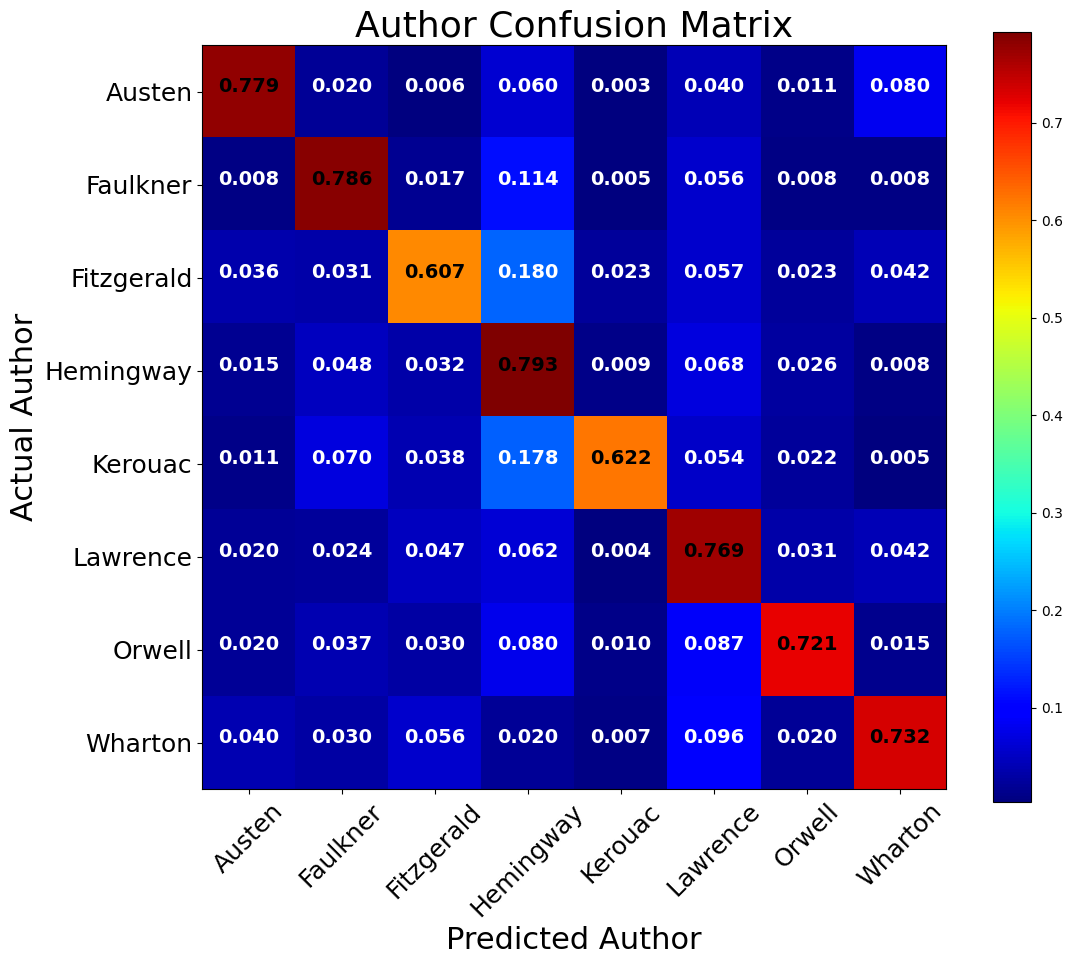

In [28]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12, 10))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Author Confusion Matrix", cmap="jet")
plt.show()